# Satellite Land Cover trend assessment for Spatial Planning and Land Management

Production date: 01-07-2024

Produced by: Inês Girão e Luís Figueiredo (+ATLANTIC)

## 🌍 Use case: Using land cover products to quantify urbanization trends

## ❓ Quality assessment question
* **Is the dataset accurate and consistent for the analysis of urbanization trends in the Iberian Peninsula?**

Land Cover data is an invaluable resource for a wide range of fields, from climate change research to urban planning. Land Cover products that provide historical timelines enable scientists, policymakers, and planners to understand and analyse the transformation of land cover over recent decades [[1]](https://ec.europa.eu/eurostat/en/web/products-statistical-books/-/ks-01-16-691)[[2]](https://www.fao.org/3/cc3017en/online/state-food-security-and-nutrition-2023/drivers-patterns-dynamics-urbanization.html).

This notebook will access the ***Land cover classification gridded maps from 1992 to present derived from satellite observations*** (henceforth, LC) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse the spatial patterns of the LC over a given Area of Interest (AoI) and time.



## 📢 Quality assessment statement

* The dataset's spatial resolution captures regional urbanization trends effectively, with clear differentiation of growth rates across high-growth areas (e.g., coastal regions) and low-growth areas (e.g., rural interiors).

* The dataset's annual updates enable consistent tracking of urbanization trends from 1992 to the present. Observed smooth year-over-year changes in urban area coverage demonstrate the reliability of temporal continuity.

* High Mann-Kendall tau values and low p-values in the analysis validate the strong positive trends across most regions, reinforcing the dataset's reliability for identifying urbanization dynamics.



![UrbanizationSeries](Urbanization_Map_Series.png)

## 📋 Methodology

**This Use Case comprises the following steps:**

**[1. Define the AoI, search and download LC data.](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-1)**

**[2. Inspect and view data for the defined AoI (Iberian Peninsula).](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-2)**

**[3. Analyzing Temporal Trends](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3)**

***[3.1. Map afforestation/deforestation trends by NUTS regions in the AoI.](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3.1)***

***[3.2. Plot Trend Analysis by NUTS regions in the AoI](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3.2)***

**[4.Main Takeaways](C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-5)**

## 📈 Analysis and results

(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-1)=
### 1. Define the AoI, search and download LC data.
Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [ ]:
!pip install cdsapi

##### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [8]:
# Import packages
import pandas as pd
import geopandas as gpd # import vector geospatial data
import numpy as np 
import xarray as xr

import matplotlib.pyplot as plt # plot graphs
import matplotlib.colors as colors
from shapely.geometry import box
from shapely.geometry import Polygon
from matplotlib.colors import TwoSlopeNorm
import dask
from scipy.stats import kendalltau, theilslopes

import regionmask # transform attributes and geometries into specific regions
from c3s_eqc_automatic_quality_control import download, plot, utils 

plt.style.use("seaborn-v0_8-notebook") # predefined style of all graphical outputs

##### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'Satellite observations' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the [Global Climate Observing System (GCOS) convention requirements](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245). LULC maps correspond to a global classification scheme, encompassing 22 classes. For intercomparison consistency, <ins>LC classes are grouped into the six IPCC land categories:</ins> **cropland, forest, grassland, wetland, settlement, and other land (shrubland, sparse vegetation, bare area and water)**, as gathered from several international sources.

The dataset consists of 2 versions (v2.0.7 produced by the European Space Agency (ESA) Climate Change Initiative (CCI) and v2.1.1 produced by Copernicus Climate Change Service (C3S)).

Data specifications for this use case:
* **Years:** 1992 to 2022 (bi-annual)
* **Version:** v2.0.7 before 1992 and v2.1.1 after 2016
* **Format:** Zip files

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook. Having copied the API request, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [2]:
#Years to download
years = [1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022]


In [3]:
# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2_0_7cds" if year < 2016 else "v2_1_1",
        "year": str(year),
        "area": [45, -10, 35, 4] # Region of interest (Iberian Peninsula)
    }
    for year in years
]

In [ ]:
# Download and regionalize by AoI
ds = download.download_and_transform(
    collection_id,
    requests,
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")
 

In [5]:
#Inspect the database
ds

<xarray.Dataset> Size: 4GB
Dimensions:              (year: 16, latitude: 3600, longitude: 5040, bounds: 2)
Coordinates:
    lat_bounds           (longitude, latitude, bounds) float64 290MB dask.array<chunksize=(1680, 1200, 1), meta=np.ndarray>
    lon_bounds           (longitude, bounds) float64 81kB dask.array<chunksize=(5040, 2), meta=np.ndarray>
    time_bounds          (longitude, year, bounds) datetime64[ns] 1MB dask.array<chunksize=(5040, 1, 2), meta=np.ndarray>
  * latitude             (latitude) float64 29kB 45.0 45.0 44.99 ... 35.0 35.0
  * longitude            (longitude) float64 40kB -9.999 -9.996 ... 3.996 3.999
  * year                 (year) int64 128B 1992 1994 1996 ... 2018 2020 2022
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (year, latitude, longitude) uint8 290MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    processed_flag       (year, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    current_pixel_state  (year, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    observation_count    (year, latitude, longitude) uint16 581MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    change_count         (year, latitude, longitude) uint8 290MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    crs                  (year, longitude) int32 323kB dask.array<chunksize=(1, 5040), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-2)=
### 2. Inspect and view data for the defined AoI (Iberian Peninsula)
#### Compute Land Cover classes area coverage for each NUTS 2 region

To further identify changes in LC patterns, in this user question, NUTS 2 will be used, providing the information reggarding the main regions/parcels of the Iberian Peninsula.

The NUTS are a hierarchical system divided into 3 levels (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correpsond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 


The step below masks the Land Cover data according to the NUTS 2 boundaries and calculate the area of each pixel (weighted by the cosine of Latitude). For each NUTS 2, we proceed with the analysis and visual inspection of Land Cover areas per class and corresponding percentages during the elected period.

#### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [6]:
# Configure Dask
dask.config.set(scheduler='threads', **{'array.slicing.split_large_chunks': True})

# Define CRS and bounding box for Iberian Peninsula
crs_wgs84 = "EPSG:4326"
iberian_bbox = box(-10, 36, 3.5, 44)

# Load and filter GeoDataFrame
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"
gdf = gpd.read_file(shapefile_url)
gdf = gdf[gdf["LEVL_CODE"] == 2]
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]  # Spain (ES) and Portugal (PT)
gdf = gdf.to_crs(crs_wgs84)
gdf = gdf[gdf.intersects(iberian_bbox)]
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

if gdf.empty:
    raise ValueError("No valid geometries found after filtering.")

# Ensure dataset CRS is set
if ds.rio.crs is None:
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)

# Ensure dataset coordinates overlap with the filtered regions
filtered_lon_min, filtered_lat_min, filtered_lon_max, filtered_lat_max = gdf.total_bounds
if (
    ds["longitude"].min().values > filtered_lon_max
    or ds["longitude"].max().values < filtered_lon_min
    or ds["latitude"].min().values > filtered_lat_max
    or ds["latitude"].max().values < filtered_lat_min
):
    raise ValueError(
        "Dataset coordinates do not overlap with the filtered regions. Check dataset and region alignment."
    )

# Subset dataset to valid ranges
ds = ds.sel(
    longitude=slice(
        max(filtered_lon_min, ds["longitude"].min().values),
        min(filtered_lon_max, ds["longitude"].max().values)
    ),
    latitude=slice(
        min(filtered_lat_max, ds["latitude"].max().values),
        max(filtered_lat_min, ds["latitude"].min().values)
    )
)

# Check subsetted dataset dimensions
if ds["longitude"].size == 0 or ds["latitude"].size == 0:
    raise ValueError("Subsetting resulted in an empty dataset. Check the bounds and ensure overlap.")

# Create the regionmask
regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")

# Create a 2D mask
mask = regions.mask(ds["longitude"], ds["latitude"])

ds= ds.where(mask.notnull(), drop=True)

#### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by the cosine of Latitude).

In [7]:
# Scaling factor for conversion (constant longitude resolution)
scaling_factor = 0.002778  # Degrees
resolution_lon_km = scaling_factor * 111.195  # Longitude resolution in kilometers

# Use the latitude values directly from the dataset
lats = ds["latitude"]

# Calculate the difference between consecutive latitude values
lat_diff = np.abs(np.diff(lats.values))  # Absolute differences
lat_diff = np.append(lat_diff, lat_diff[-1])  # Assume the last cell has the same size as the one before

# Convert latitude differences to kilometers
resolution_lat_km = lat_diff * 111.195  # Latitude-dependent resolution

# Compute the grid cell area for each latitude
grid_cell_area = resolution_lon_km * resolution_lat_km * np.cos(np.radians(lats))

# Assign attributes to the grid cell area
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Grid cell area",
    "units": "km²",
}

# Add the grid cell area as a coordinate to the dataset
ds = ds.assign_coords(cell_area=("latitude", grid_cell_area.data))  # Use `.data` to extract the array



(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3)=
### 3. Analyzing Temporal Trends of Urbanization
#### Evaluating the direction and magnitude of changes over time

We employ the Mann-Kendall trend test to identify potential trends within time-series data, focusing on examining whether there exists a statistically significant increase or decrease in urban areas over the years. A positive Mann-Kendall test result indicates an upward trend, suggesting an increase in urban area over time, while a negative result signals a downward trend, indicating a reduction in urban area. If the test yields a statistically significant result (commonly p-value < 0.05), it implies that the observed trend is unlikely to be due to random variation and is likely reflective of a true underlying trend.

Complementing the Mann-Kendall test, the Theil-Sen estimator provides a robust non-parametric method to estimate the slope of the trend of the time series. The magnitude of the slope indicates the rate of change: a positive slope implies an increase in urbanization, while a negative slope suggests a decrease. The Theil-Sen estimator is particularly useful because it provides a reliable estimate of the median rate of change, even in the presence of outliers or non-normal data.

Interpreting these two tests together offers deeper insight: the Mann-Kendall test tells us whether there is a trend and the direction of that trend, while the Theil-Sen estimator quantifies how fast the urbanization is occurring (or declining). This combination allows for a comprehensive understanding of the trend's direction and its rate of change, providing robust evidence for urbanization patterns over time.

#### Select Urban Classes and Prepare Dataset

In [9]:
# Define urban classes
urban_classes = [190]

# Create a mask for urban areas
urban_mask = ds['lccs_class'].isin(urban_classes)

# Masked urban area using cell area
ds_urban_area = ds['cell_area'].where(urban_mask)

# Stack latitude and longitude into a single dimension
ds_urban_area = ds_urban_area.stack(stacked_lat_lon=("latitude", "longitude"))

# Create a stacked mask and align dimensions
stacked_mask = mask.stack(stacked_lat_lon=("latitude", "longitude"))
stacked_mask.name = "stacked_mask"

# Attach the stacked mask to the dataset
ds_urban_area = ds_urban_area.assign_coords(stacked_mask=stacked_mask)

# Group by regions and compute urban area for each year
urban_area_by_region = (
    ds_urban_area.groupby("stacked_mask")
    .sum(dim="stacked_lat_lon")
    .compute()
)

#### Compute trends by region

In [10]:
results = []
growth = {}

for reg, reg_area in urban_area_by_region.groupby("stacked_mask"):
    if np.isnan(reg):  # Skip NaN regions
        continue

    # Ensure valid region indexing and naming
    region_name = regions[int(reg)].name
    years = ds_urban_area['year'].values
    values = reg_area.values.flatten()  # Flatten in case of higher-dimensional arrays

    # Save growth data by year
    if len(values) > 0:
        growth[region_name] = {int(year): float(value) for year, value in zip(years, values)}
    else:
        growth[region_name] = {}  # Handle regions with no data

    # Calculate temporal trends (slope, tau, and p-value)
    if len(values) > 1:  # Ensure enough data points for statistical calculations
        tau, p_value = kendalltau(years, values)
        th_slope, intercept, _, _ = theilslopes(values, years)
    else:
        tau, p_value, th_slope = np.nan, np.nan, np.nan

    # Add results to the list
    for year, value in zip(years, values):
        results.append({
            "Region": region_name,
            "Year": int(year),
            "Urban_Area": float(value),
            "Slope": th_slope,
            "Tau": tau,
            "P_Value": p_value
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Add geometry to results_df
if 'NUTS_NAME' in gdf.columns:
    results_df = pd.merge(results_df, gdf[['NUTS_NAME', 'geometry']], left_on="Region", right_on="NUTS_NAME", how="left")
else:
    print("Warning: NUTS_NAME column not found in gdf.")

# Ensure results_df is a GeoDataFrame
if not isinstance(results_df, gpd.GeoDataFrame):
    results_df = gpd.GeoDataFrame(results_df, geometry=gpd.GeoSeries(results_df['geometry']), crs="EPSG:4326")

# Reproject the GeoDataFrame to a projected CRS (EPSG:3035 is a good choice for Europe)
results_df = results_df.to_crs("EPSG:3035")

# Calculate the total area of each region (in square kilometers)
results_df["Total_Area"] = results_df.geometry.area / 10**6  # Convert from m² to km²

(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3.1.)=
### 3.1. Map Urbanization trends maps by NUTS regions in the AoI

#### Map biennially urban area percentage in the AoI regions

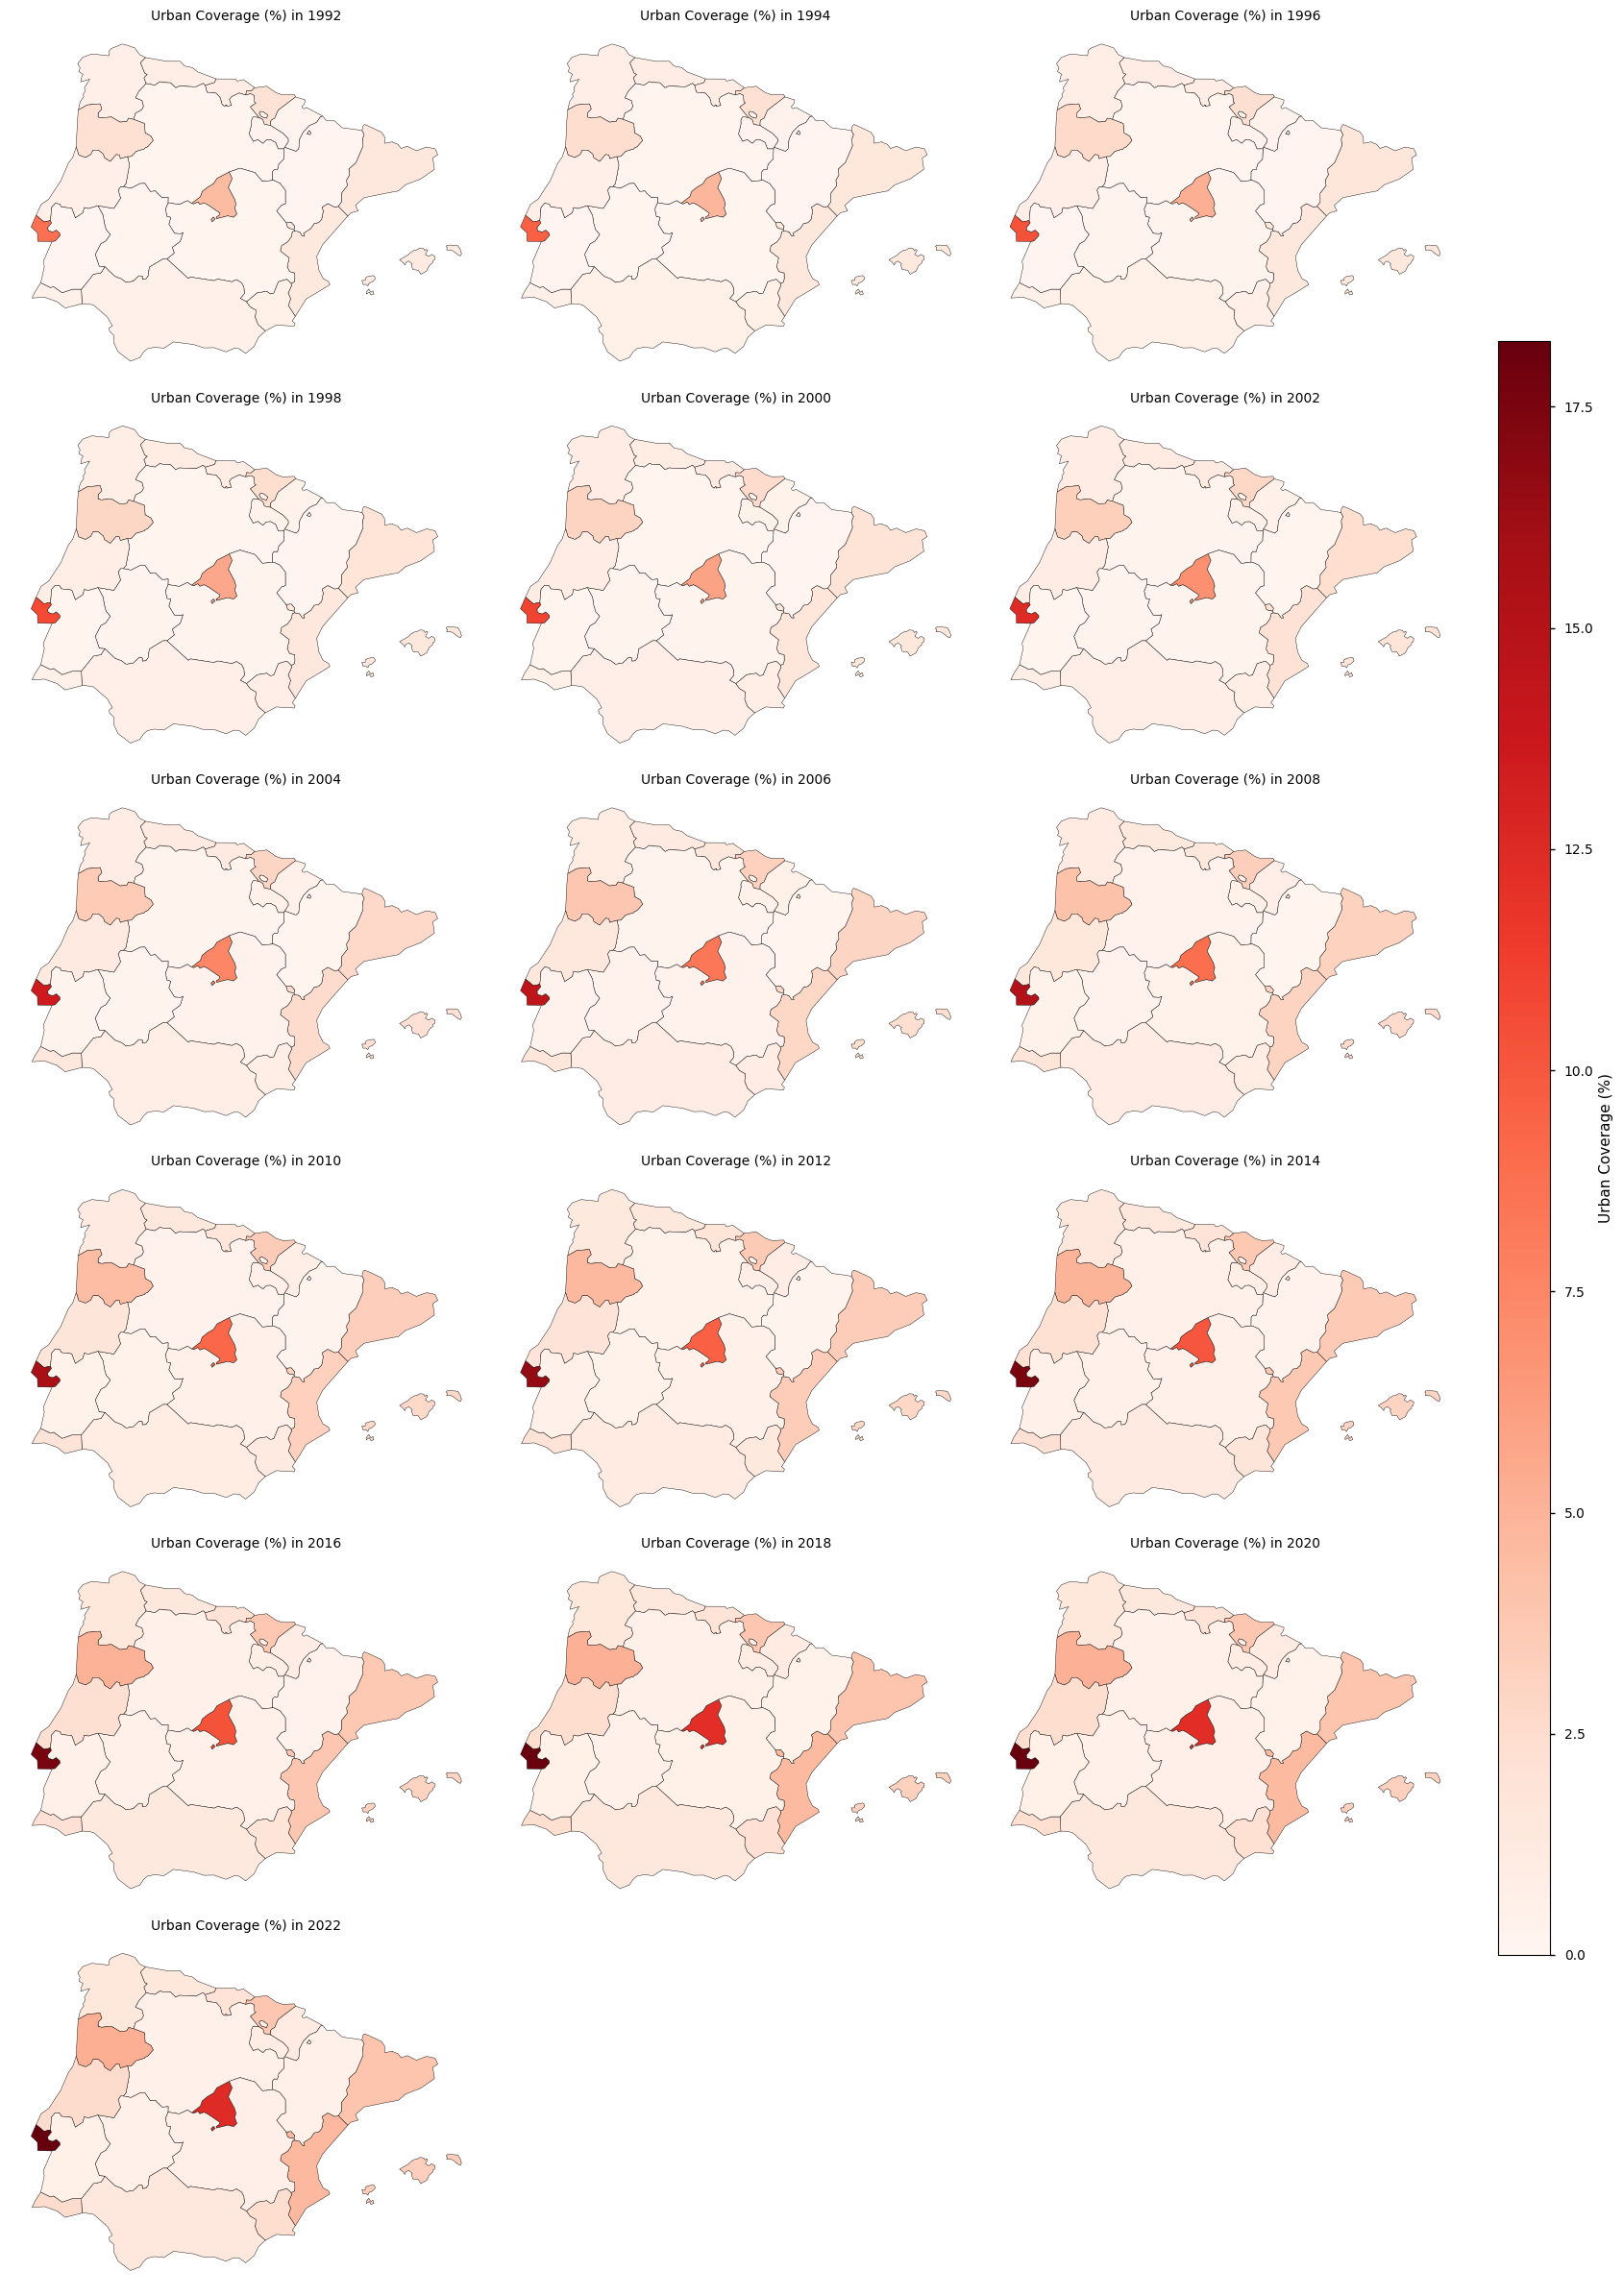

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Ensure 'Year' is converted to string if needed
results_df['Year'] = results_df['Year'].astype(str)

#Calculate Urban Percentage
results_df['Urban_Percentage'] = (results_df['Urban_Area'] / results_df['Total_Area']) * 100

# Pivot the data to have years as columns
Urban_pivot = results_df.pivot(index='Region', columns='Year', values='Urban_Percentage').reset_index()

# Extract years for plotting
years = [col for col in Urban_pivot.columns if col.isdigit()]

# Normalize color scale across all maps based on percentage coverage
norm_percentage = Normalize(vmin=0, vmax=results_df['Urban_Percentage'].max())

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Plot each year in a separate subplot
for idx, year in enumerate(years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'] == year]
    results_df_year.plot(column='Urban_Percentage', cmap="Reds", ax=ax, edgecolor="k", norm=norm_percentage)
    ax.set_title(f"Urban Coverage (%) in {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Step 8: Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap="Reds", norm=norm_percentage)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Urban Coverage (%)")

plt.show()


#### Map biennially urban area change

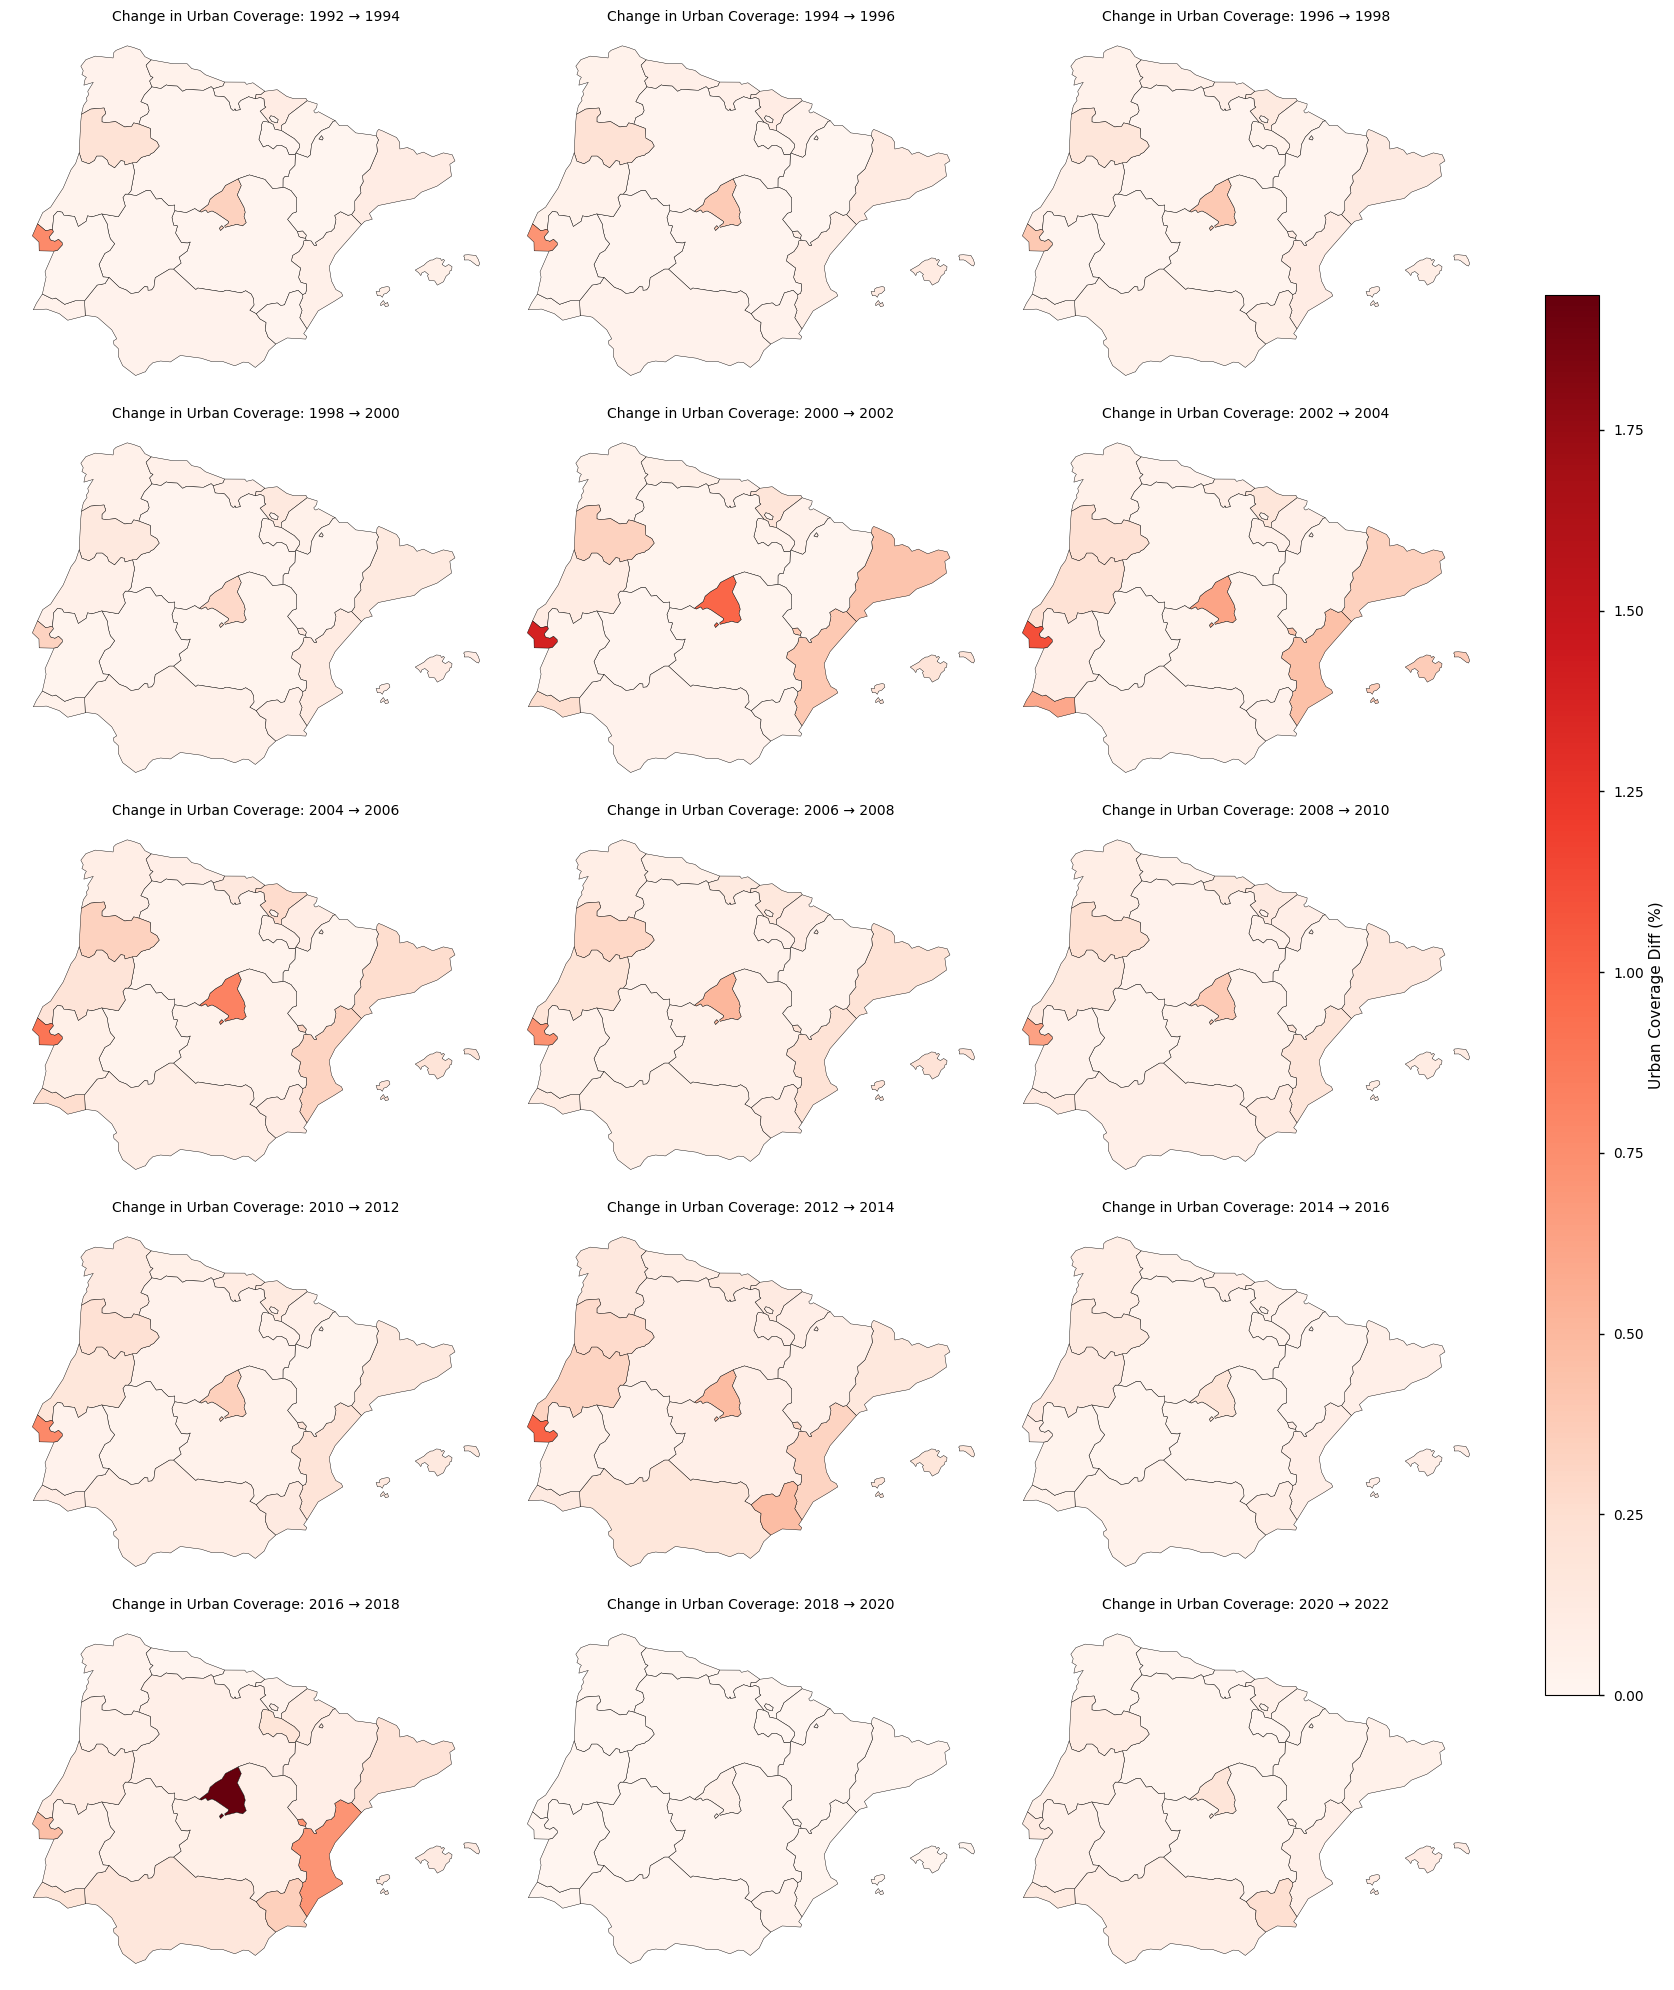

In [12]:
# Calculate the year-over-year percentage differences for each region
results_df['Urban_Percentage_Diff'] = results_df.groupby('Region')['Urban_Percentage'].diff()

# Automatically exclude the first year
first_year = int(results_df['Year'].min())  # Ensure the first year is an integer
filtered_years = sorted(results_df['Year'].astype(int).unique())  # Ensure years are integers
filtered_years = [year for year in filtered_years if year != first_year]  # Exclude the first year

# Calculate vmin and vmax for normalization
urban_diff_min = results_df['Urban_Percentage_Diff'].min()
urban_diff_max = results_df['Urban_Percentage_Diff'].max()

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(filtered_years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Improved color scale
cmap = "Reds"  # Diverging colormap for better visualization of changes

# Plot each year in a separate subplot
for idx, year in enumerate(filtered_years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'].astype(int) == year]
    previous_year = year - 2  # Year difference
    results_df_year.plot(
        column='Urban_Percentage_Diff',
        cmap=cmap,
        ax=ax,
        edgecolor="k",
        vmin=urban_diff_min,
        vmax=urban_diff_max
    )
    ax.set_title(f"Change in Urban Coverage: {previous_year} → {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(filtered_years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for the color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=urban_diff_min, vmax=urban_diff_max))
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Urban Coverage Diff (%)")

plt.show()



#### Map Analys

**How to interpret:** For each year, the percentage of the region's area that is urbanized is calculated by dividing the urban area by the total area of the region and multiplying by 100. This results in the urban area coverage expressed as a percentage of the total area for each region, for each year.

**Analysis:** 

* Comunidad de Madrid and Área Metropolitana de Lisboa consistently stand out with the highest levels of urban coverage, as evidenced by its strong green and yellow colors throughout the maps. 
* Coastal areas tend to show a higher degree of urban converage compared to inland areas. 

#### Map Analys



(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-3.2.)=
### 3.2. Plot Forest trends maps by NUTS regions in the AoI

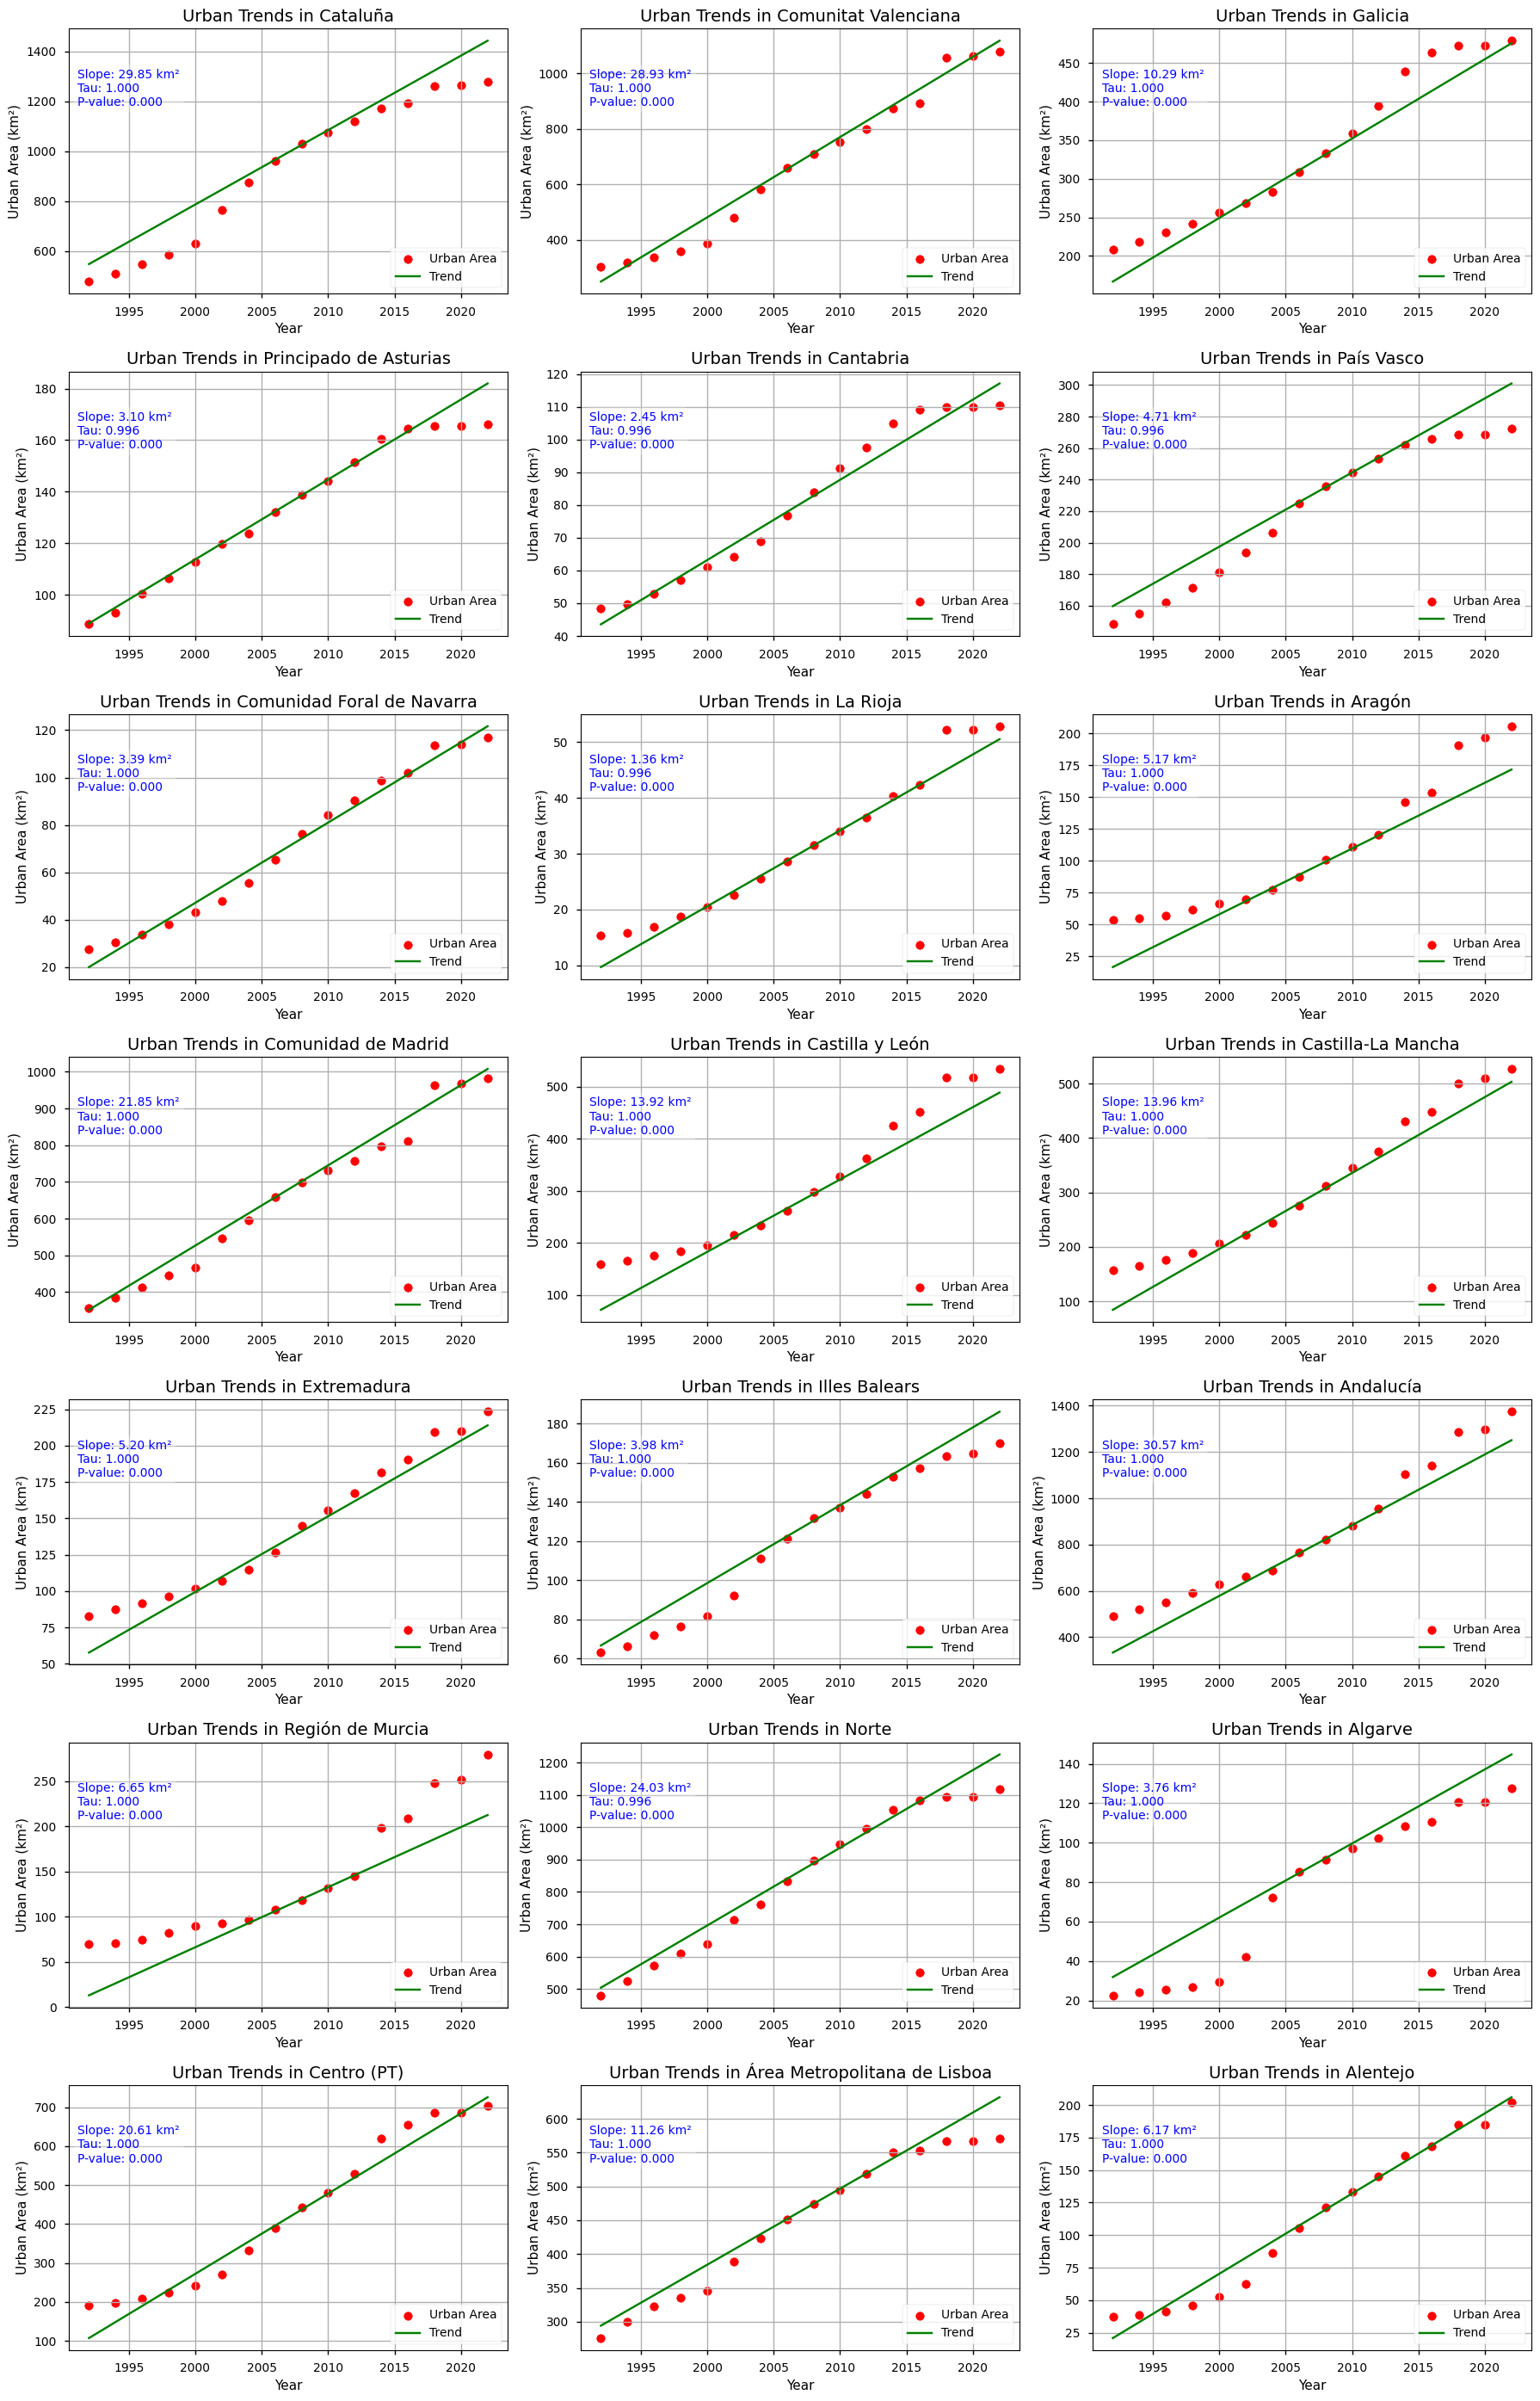

In [13]:
# Ensure years are numeric
results_df["Year"] = results_df["Year"].astype(int)

# Plotting all regions
unique_regions = results_df["Region"].unique()
n_cols = 3
n_rows = int(np.ceil(len(unique_regions) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for idx, region in enumerate(unique_regions):
    ax = axes[idx]
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values.astype(float)  # Ensure years are floats
    Urban_area = region_data["Urban_Area"].values

    # Trend analysis
    tau, p_value = kendalltau(years, Urban_area)
    th_slope, intercept, _, _ = theilslopes(Urban_area, years)

    # Plot data and trend line
    ax.scatter(years, Urban_area, color='r', label='Urban Area')
    ax.plot(years, th_slope * years + intercept, color='g', label=f'Trend')

    # Customize plot
    ax.set_title(f"Urban Trends in {region}", fontsize=14)
    ax.set_xlabel("Year")
    ax.set_ylabel("Urban Area (km²)")
    ax.legend()
    ax.grid()

    # Add tau and p-value inside the plot
    ax.text(
        0.02, 0.85, 
        f"Slope: {th_slope:.2f} km²\nTau: {tau:.3f}\nP-value: {p_value:.3f}",
        transform=ax.transAxes, fontsize=10, color="blue", 
        verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3, color="white")
    )

# Hide unused subplots
for idx in range(len(unique_regions), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


#### Plot the regions with the lowest and highest slope

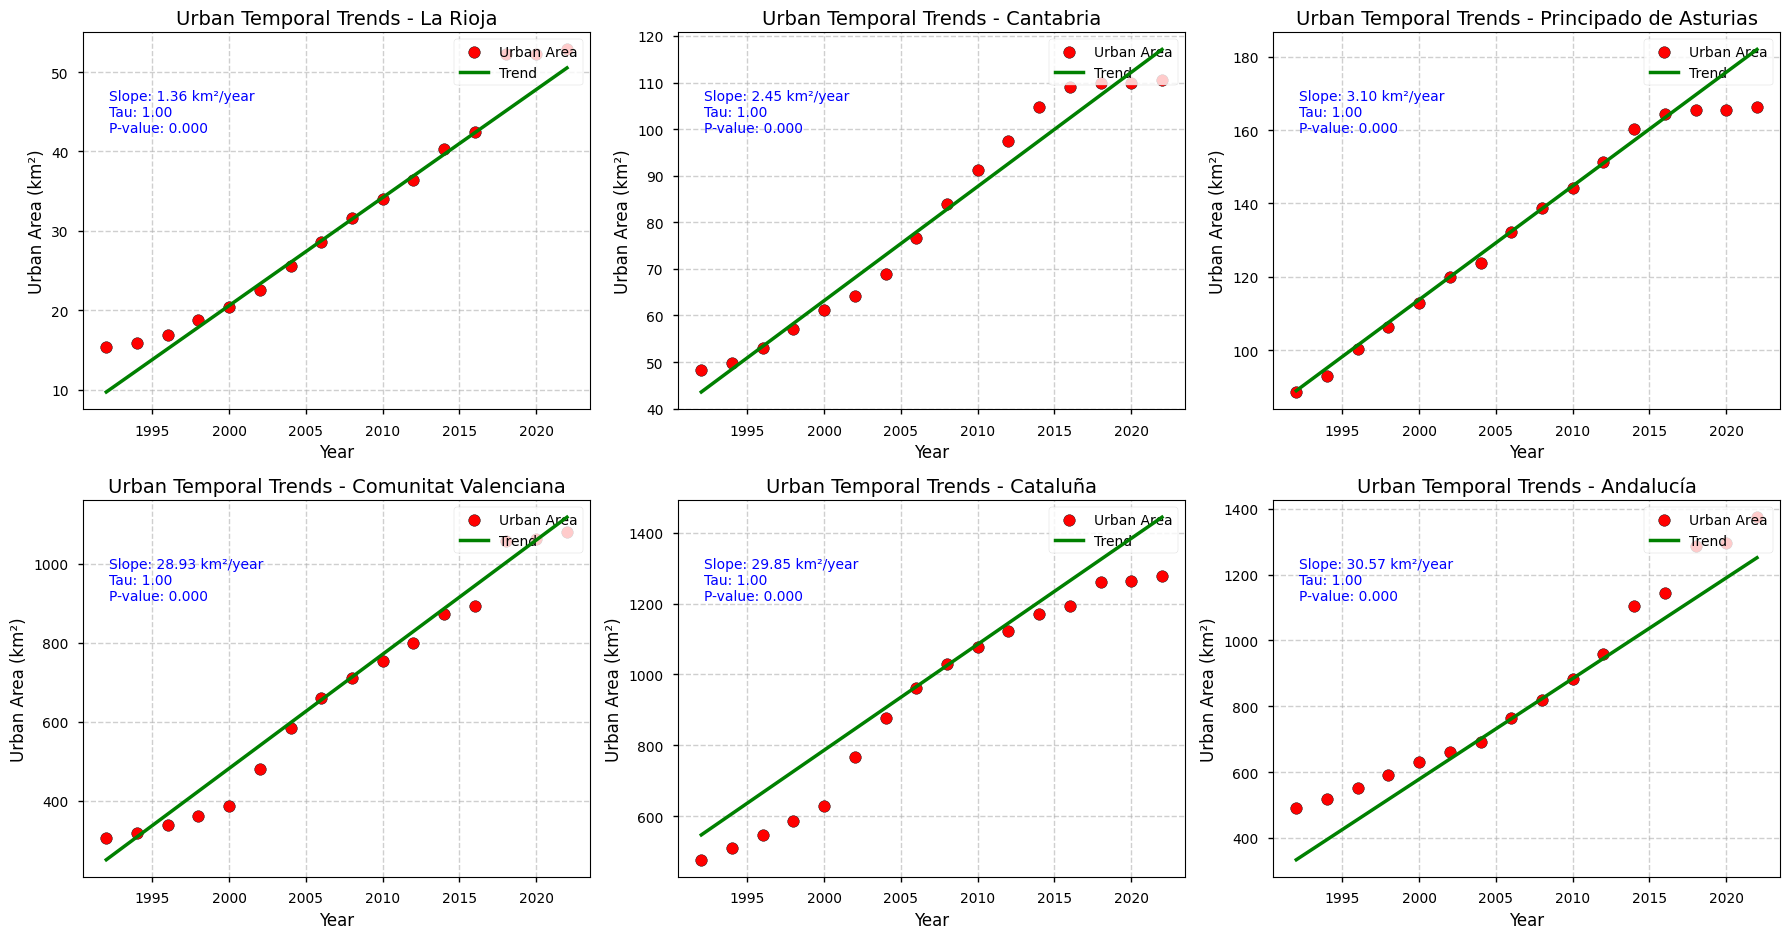

In [14]:
# Select top and bottom regions by slope directly from the results_df
sorted_regions = results_df.groupby("Region")["Slope"].mean().sort_values()
bottom_regions = sorted_regions.head(3)  # Bottom 3 regions with the lowest negative slopes
top_regions = sorted_regions.tail(3)  # Top 3 regions with the highest positive slopes
selected_regions = bottom_regions.index.tolist() + top_regions.index.tolist()

# Plot settings for consistency
fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)  # 2 rows, 3 columns
axes = axes.flatten()

# Iterate over selected regions
for idx, region in enumerate(selected_regions):
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values
    values = region_data["Urban_Area"].values
    
    # Calculate trend line and statistics
    tau, p_value = kendalltau(years, values)
    th_slope, intercept, _, _ = theilslopes(values, years)

    # Scatter plot and trend line
    axes[idx].scatter(years, values, label="Urban Area", color="red", s=70, marker="o", edgecolor="black", zorder=5)
    axes[idx].plot(years, th_slope * years + intercept, color="green", linewidth=2.5, linestyle="-", label="Trend", zorder=10)

    # Titles and labels
    axes[idx].set_title(f"Urban Temporal Trends - {region}", fontsize=14)
    axes[idx].set_xlabel("Year", fontsize=12)
    axes[idx].set_ylabel("Urban Area (km²)", fontsize=12)
    axes[idx].grid(True, linestyle="--", alpha=0.6)

    # Add slope and statistical information inside the plot
    axes[idx].text(
        0.05, 0.85, f"Slope: {th_slope:.2f} km²/year\nTau: {tau:.2f}\nP-value: {p_value:.3f}",
        fontsize=10, color="blue", transform=axes[idx].transAxes, ha="left", va="top"
    )

    # Legend
    axes[idx].legend(loc="upper right", fontsize=10)

# Hide unused subplots if fewer than 6 regions
for idx in range(len(selected_regions), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



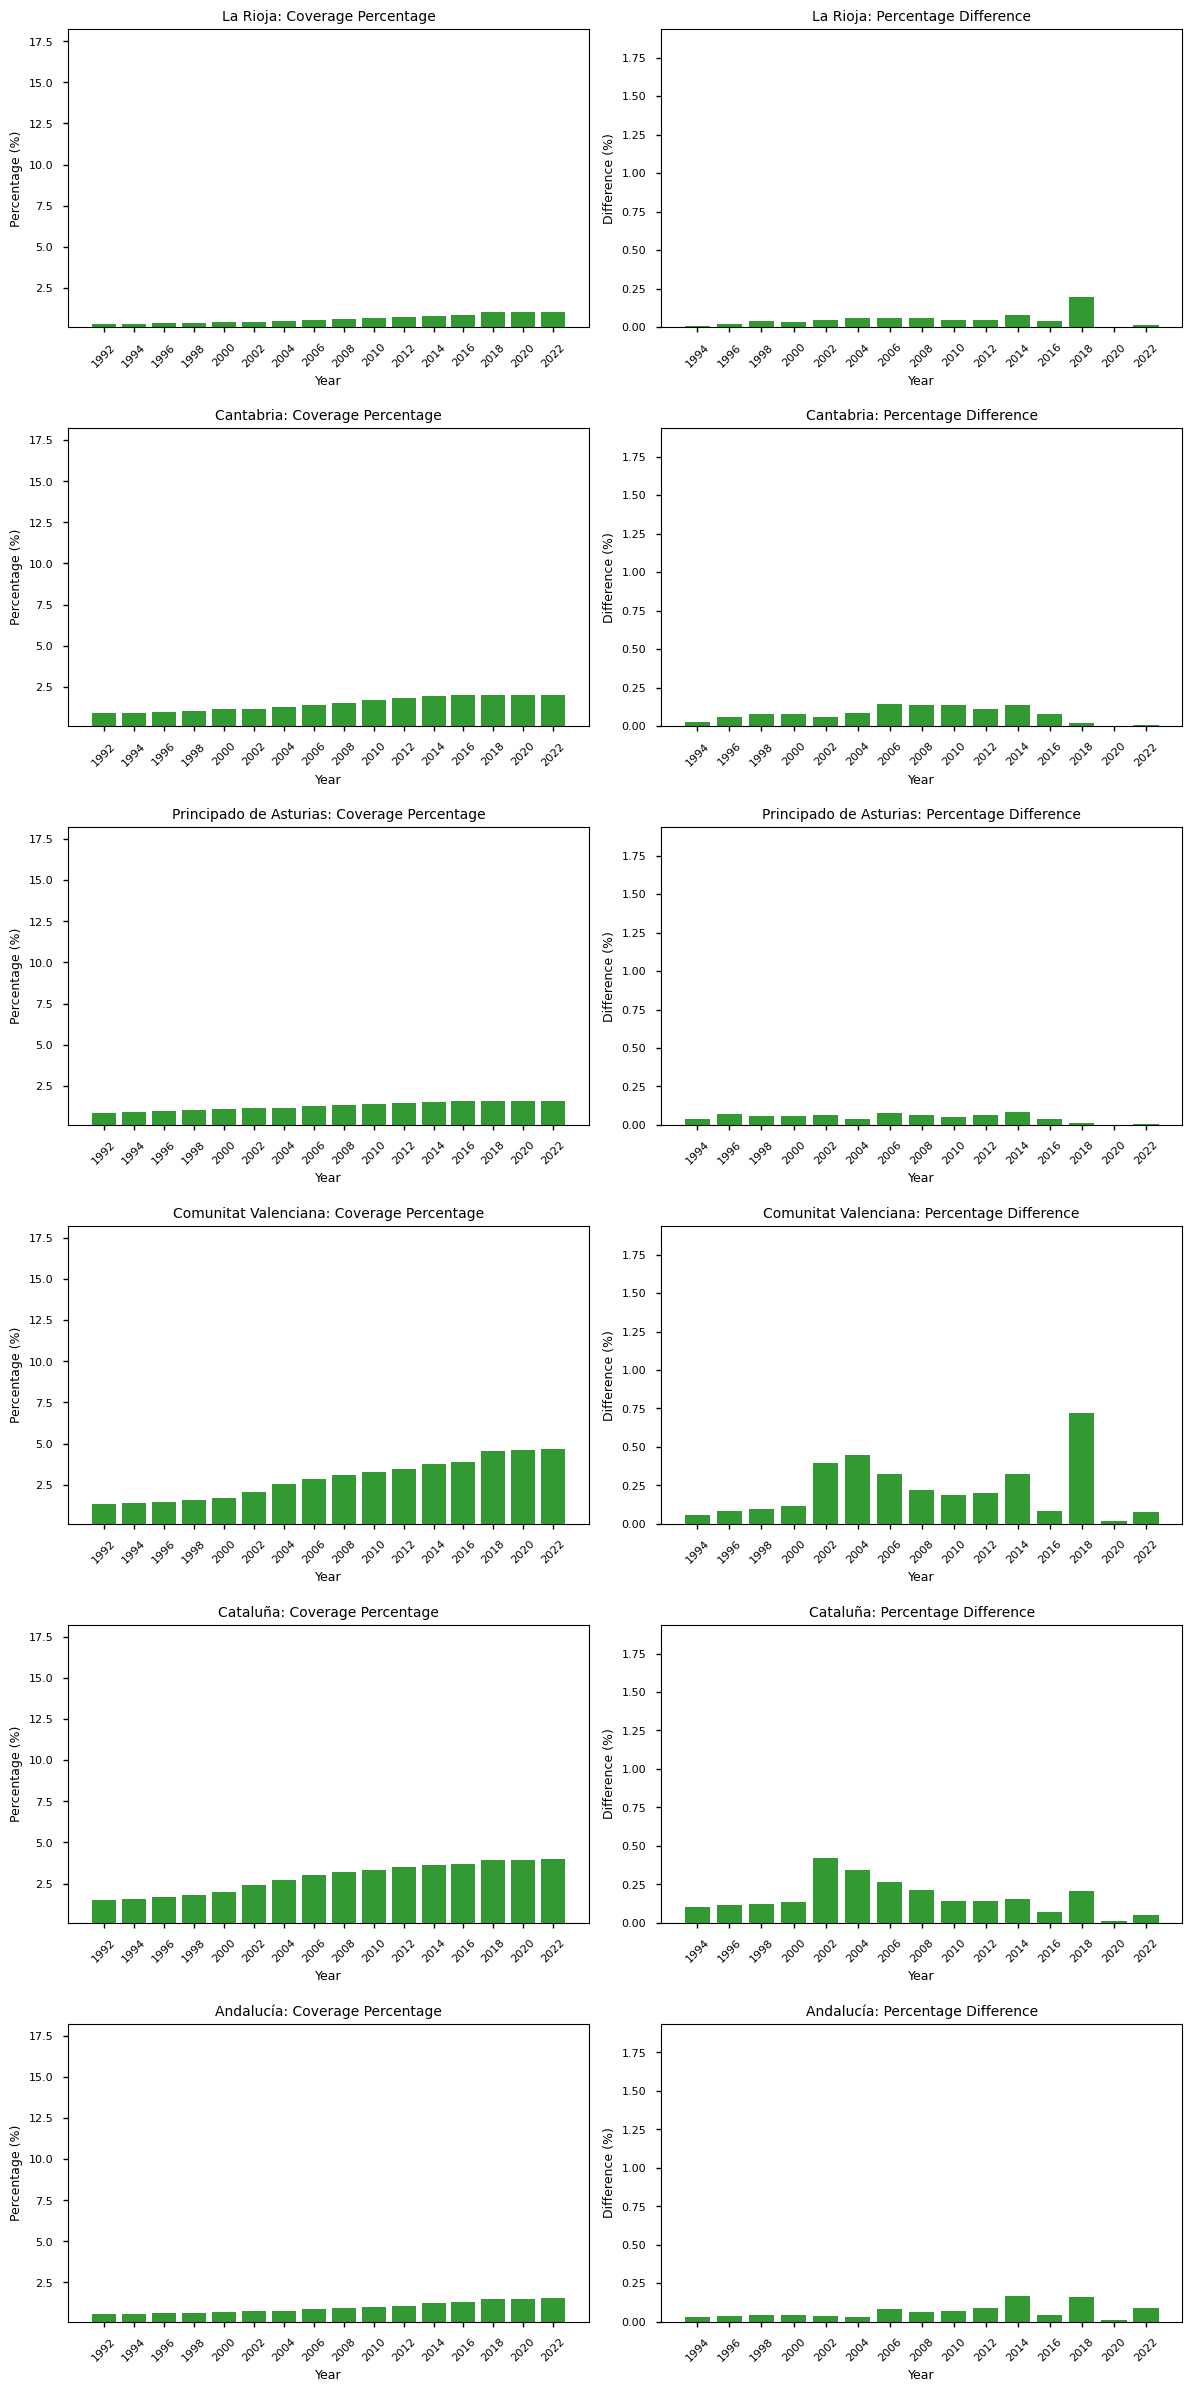

In [18]:
# Get global y-axis limits for all plots
coverage_min = results_df['Urban_Percentage'].min()
coverage_max = results_df['Urban_Percentage'].max()
diff_min = results_df['Urban_Percentage_Diff'].min()
diff_max = results_df['Urban_Percentage_Diff'].max()

# Plot the graphs for each region
num_regions = len(selected_regions)
fig, axes = plt.subplots(nrows=num_regions, ncols=2, figsize=(12, 4 * num_regions))  # Adjusted figure size

# Loop through each selected region
for idx, region in enumerate(selected_regions):
    region_data = results_df[results_df['Region'] == region].sort_values('Year')
    years = region_data['Year'].astype(str).tolist()
    percentages = region_data['Urban_Percentage'].values
    percentage_diff = region_data['Urban_Percentage_Diff'].values

    # Plot coverage percentage
    axes[idx, 0].bar(years, percentages, alpha=0.8, color='green')
    axes[idx, 0].set_title(f'{region}: Coverage Percentage', fontsize=10)
    axes[idx, 0].set_xlabel('Year', fontsize=9)
    axes[idx, 0].set_ylabel('Percentage (%)', fontsize=9)
    axes[idx, 0].set_ylim(coverage_min, coverage_max)  # Consistent y-axis limits
    axes[idx, 0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx, 0].tick_params(axis='y', labelsize=8)

    # Plot percentage difference
    bar_colors_diff = ['green' if diff > 0 else 'red' for diff in percentage_diff[1:]]  # Skip first NaN difference
    axes[idx, 1].bar(years[1:], percentage_diff[1:], alpha=0.8, color=bar_colors_diff)
    axes[idx, 1].set_title(f'{region}: Percentage Difference', fontsize=10)
    axes[idx, 1].set_xlabel('Year', fontsize=9)
    axes[idx, 1].set_ylabel('Difference (%)', fontsize=9)
    axes[idx, 1].set_ylim(diff_min, diff_max)  # Consistent y-axis limits
    axes[idx, 1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx, 1].tick_params(axis='y', labelsize=8)

# Adjust layout
plt.tight_layout(pad=1.0, h_pad=1.5, w_pad=1.0)
plt.show()


#### Map & Plot Analysis

**How to interpret the plots:** 

***Bar charts***
* Percentage Coverage: Indicates the proportion of a region covered by urban areas for each year. It provides a measure of cumulative urban development.
* Percentage Difference: Displays year-to-year changes in urban area coverage. 

***Trend Plots***

* The temporal trend plots illustrate the changes in urban area coverage over time. The red dots indicate the urban area coverage for each year, while the green line represents the linear regression trend, providing an overview of the overall rate of urban area growth. The slope reflects the average annual growth in urban area (measured in km²/year), the Mann-Kendall Tau value indicates the strength of the trend (with values near 1.0 suggesting a strong and consistent upward trend), and the P-value of 0.000 confirms that these trends are statistically significant.

**Analysis:** 

* Regional trends in urban growth reveal distinct patterns across different areas. In La Rioja, there is a consistent upward trend with a slope of 1.36 km²/year. Although the percentage coverage remains relatively small, it steadily increases over time, with urban growth accelerating after 2010 and minimal year-over-year fluctuations in coverage difference. Cantabria shows a moderate growth trend with a slope of 2.45 km²/year. Urban area percentage gradually increases, with only a few spikes in percentage difference, and growth stabilizes post-2014.

* In Principado de Asturias, urban growth occurs at a slope of 3.10 km²/year. Urban coverage expands steadily, without any sharp increases in a single year, and the percentage difference charts indicate uniform growth over decades. Comunitat Valenciana stands out with one of the highest urban growth rates at 28.93 km²/year, marked by significant cumulative expansion in urban area percentage over time. The percentage difference peaks in 2016, signaling a surge in urban development around that period.

* Cataluña exhibits a high growth rate of 29.85 km²/year, characterized by a continuous upward trend and noticeable increases in cumulative urban coverage. Year-to-year differences stabilize after 2015. Andalucía, among the fastest-growing regions, has a slope of 30.57 km²/year. The percentage coverage and difference plots show sustained growth with few sharp changes, and urban development in the region remains steady, with no significant slowdown.

#### Map the slope in urbanization for the full time-period

/tmp/ipykernel_1693/2508387379.py:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  non_significant_df.plot(


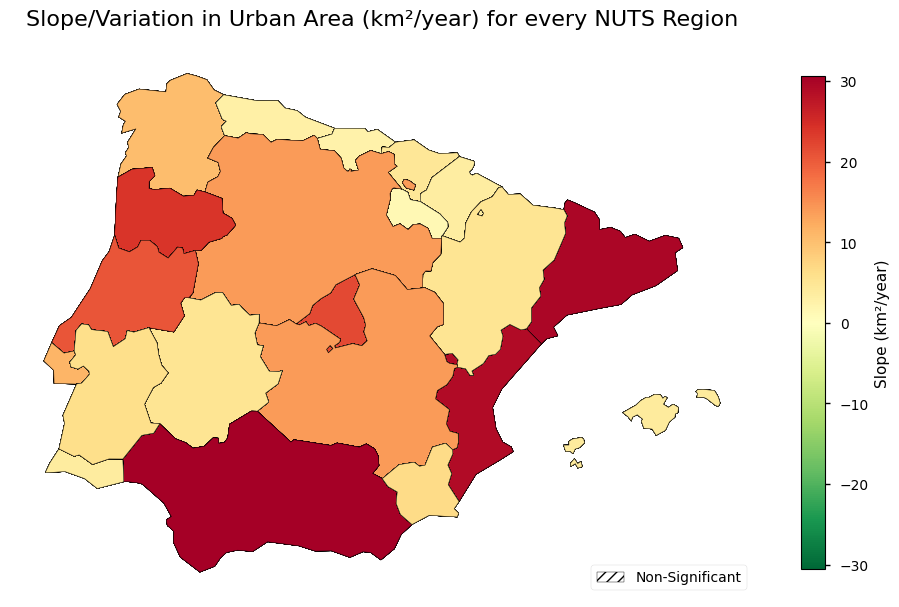

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from matplotlib.patches import Patch
import geopandas as gpd

# Ensure results_df is a GeoDataFrame
if not isinstance(results_df, gpd.GeoDataFrame):
    results_df = gpd.GeoDataFrame(results_df, geometry=gpd.GeoSeries(results_df['geometry']), crs="EPSG:4326")

# Reproject to a projected CRS (EPSG:3035 is suitable for Europe)
results_df = results_df.to_crs("EPSG:3035")

# Step 1: Check for invalid geometries
invalid_geometries = results_df[~results_df.is_valid]

# Step 2: Remove empty geometries
results_df = results_df[results_df.geometry.notnull() & ~results_df.is_empty]

# Step 3: Check total bounds again after cleaning
bounds = results_df.total_bounds

# Step 4: Proceed with plotting if bounds are valid
if np.all(np.isfinite(bounds)):
    vmax = results_df["Slope"].abs().max()  # Symmetric vmax for color scale
    cmap = "RdYlGn_r"
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all regions with original colors
    results_df.plot(
        column="Slope",
        cmap=cmap,
        ax=ax,
        norm=norm,
        edgecolor="black",
        legend=True,
        legend_kwds={"label": "Slope (km²/year)", "shrink": 0.8},
    )

    # Overlay hatching for non-significant regions
    non_significant_df = results_df[results_df["P_Value"] >= 0.05]  # Adjust column name to match results_df
    non_significant_df.plot(
        ax=ax, facecolor="none", hatch="///", edgecolor="black"
    )

    # Create a proxy artist for the legend handle
    legend_handles = [
        Patch(facecolor="white", edgecolor="black", hatch="///", label="Non-Significant")
    ]

    # Add custom legend
    ax.legend(handles=legend_handles, loc="lower right", fontsize=10)

    # Turn off axis
    ax.axis("off")

    plt.title("Slope/Variation in Urban Area (km²/year) for every NUTS Region", fontsize=16)
    plt.show()


#### Map Analysis

**How to Interpret:**

The map above represents the slope of forest area variation (km2/year) across different NUTS regions of the Iberian Peninsula. The slope values indicate the rate of change in forest area, with positive values (yellow to green) representing forest expansion and negative values (yellow to red) representing forest loss.

**Analysis**

* The eastern and southern regions of Spain, such as Comunitat Valenciana, Andalucía, and parts of Cataluña, show the steepest slopes. Followed by Comunidad Madrid and Norte (PT).

* Regions such as Área Metropolitana de Lisboa, Castilla-La Mancha, Extremadura, and parts of Aragón display moderate slopes. Urban expansion here is steady but not as pronounced as in the coastal and southern areas.

(C3S2_D520.5.3.14b_Quality_Assessment_User_Questions_LULC_UQ2_v1.5.ipynb:code-section-5)=
### 5. Main Takeaways

* The highest urban growth rates per year were observed in Cataluña , Comunitat Valenciana , and Andalucía. A peer-reviewed study  found that cities in these regions show significant urban growth rates, supported by both population increases and expansion in built-up areas [[3]](https://www.mdpi.com/2071-1050/11/24/6948). A study on Metropolitan Area of Valencia urban growth highlights significant urban expansion from the mid-1950s to 2012, with an increase of urban areas by 206% [[4]](https://doi.org/10.3232/SJSS.2019.V9.N2.03). Similarly, research on population growth and urban management in Barcelona shows considerable urban expansion over a 44-year period, emphasizing the transition from mono-centric to polycentric urban structures [[5]](https://doi.org/10.1007/S12061-021-09395-2). Furthermore, urban expansion and population dynamics in Andalucía indicate significant changes in urban areas, driven by internal migration and demographic shifts [[6]](https://revistaseug.ugr.es/index.php/cuadgeo/article/view/1711).

* By 2022, the regions with the most substantial proportion of urban areas include the Área Metropolitana de Lisboa and the Comunidad de Madrid. Lisbon's Metropolitan Area, encompassing approximately 26% of Portugal's population, has been a focal point of urbanization, with built-up areas expanding by 17% between 1990 and 2007, transforming natural and agricultural land into urban spaces [[7]](https://linkinghub.elsevier.com/retrieve/pii/S0264837715003348). Similarly, Madrid has seen extensive urban expansion, with developed areas doubling in size between 1982 and 2006, driven by infrastructure development and population growth, positioning it as a dynamic urban hub in Europe [[8]](https://www.sciencedirect.com/science/article/abs/pii/S0143622810001426?via%3Dihub). These trends highlight the significant urban growth shaping both metropolitan regions.


## ℹ️ If you want to know more

### Key Resources

* The CDS catalogue entry for the data used was [Land cover classification gridded maps from 1992 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview)

* Product User Guide and Specification of the dataset [version 2.1](https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf) and [version 2.0](https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D3.3.11-v1.0_PUGS_CDR_LC-CCI_v2.0.7cds_Products_v1.0.1_APPROVED_Ver1.pdf) 

* [Eurostat NUTS](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts) (Nomenclature of territorial units for statistics)

* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), c3s_eqc_automatic_quality_control, prepared by [BOpen](https://www.bopen.eu/)




### References

<a name="code-section-5"></a>[[1]](https://ec.europa.eu/eurostat/en/web/products-statistical-books/-/ks-01-16-691) Eurostat, Cities (Urban Audit)

[[2]](https://www.fao.org/3/cc3017en/online/state-food-security-and-nutrition-2023/drivers-patterns-dynamics-urbanization.html) Urbanisation: Trends and drivers

[[3]](https://www.mdpi.com/2071-1050/11/24/6948) Alvarez-Palau, E. J., Martí-Henneberg, J., & Solanas-Jiménez, J. (2019). Urban growth and long-term transformations in Spanish cities since the mid-nineteenth century: a methodology to determine changes in urban density. Sustainability, 11(24), 6948.

[[4]](https://doi.org/10.3232/SJSS.2019.V9.N2.03) Lozano, A., Vidal, C., & Díaz, J. (2019). Urban growth (1956-2012) and soil sealing in the metropolitan area of Valencia (Eastern Spain). Spanish Journal of Soil Science. 

[[5]](https://doi.org/10.1007/S12061-021-09395-2) Vinci, S., Egidi, G., Gay, A., & Salvati, L. (2021). Population Growth and Urban Management in Metropolitan Regions: the Contribution of Natural Balance and Migration to Polycentric Development in Barcelona. Applied Spatial Analysis and Policy, 15, 71-94. 

[[6]](https://revistaseug.ugr.es/index.php/cuadgeo/article/view/1711) Calmaestra, J. A., & Jiménez, C. (2005). La dinámica demográfica en Andalucía en el último cuarto del siglo XX. Cuadernos Geográficos, 36(1), 125–151. 

[[7]](https://doi.org/10.1016/J.LANDUSEPOL.2015.10.023.) Abrantes, P., Fontes, I., Gomes, E., & Rocha, J. (2016). Compliance of land cover changes with municipal land use planning: evidence from the Lisbon metropolitan region (1990–2007). Land Use Policy, 51, 120-134. 
 
[[8]](https://doi.org/10.1016/J.APGEOG.2010.11.002) Hewitt, R., & Escobar, F. (2011). The territorial dynamics of fast-growing regions: Unsustainable land use change and future policy challenges in Madrid, Spain. Applied Geography, 31, 650-667. 

